Running: Baseline (No Reg)
Running: L2 Regularisation
Running: Early Stopping (ES)

=== Summary of Regularisation Experiments ===
                  name  weight_decay  use_early_stopping  effective_epochs  \
0    Baseline (No Reg)         0.000               False               200   
1    L2 Regularisation         0.001               False               200   
2  Early Stopping (ES)         0.000                True               200   

   train_acc   val_acc  test_acc  generalisation_gap  
0   0.896667  0.893333  0.883333            0.013333  
1   0.896667  0.896667  0.896667            0.000000  
2   0.905556  0.900000  0.903333            0.002222  


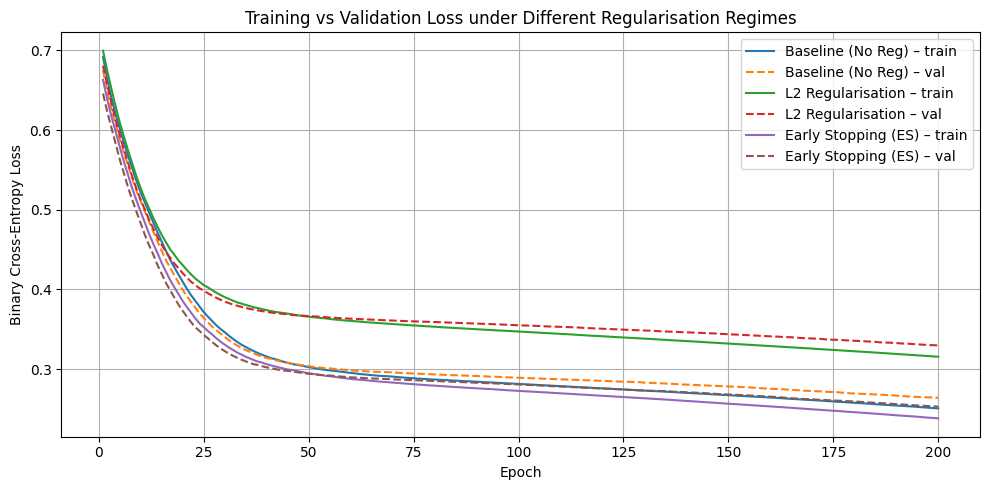

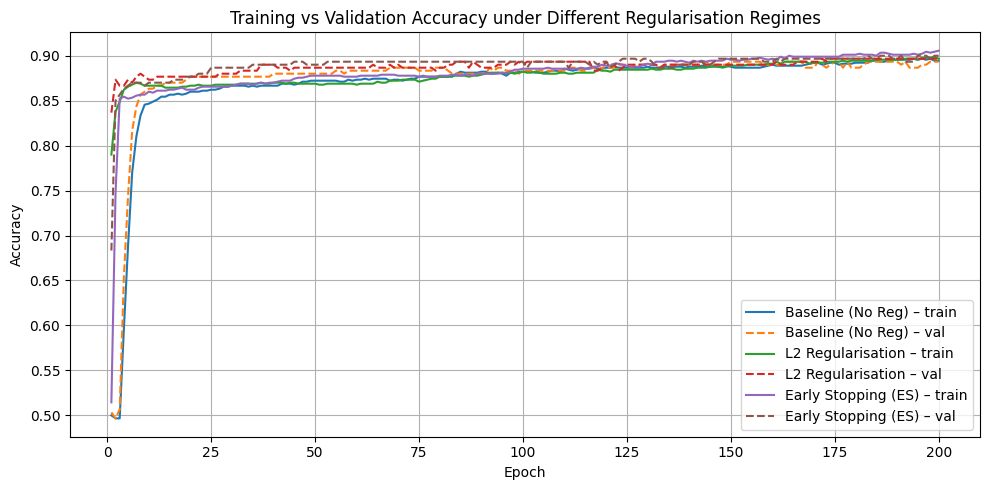

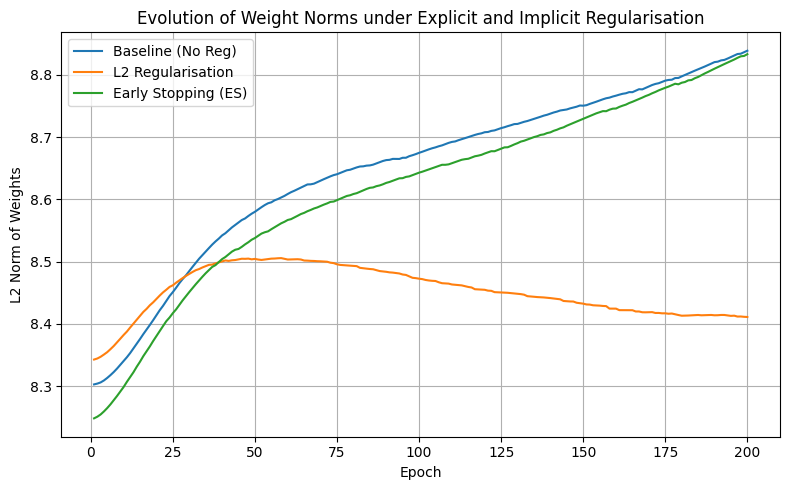

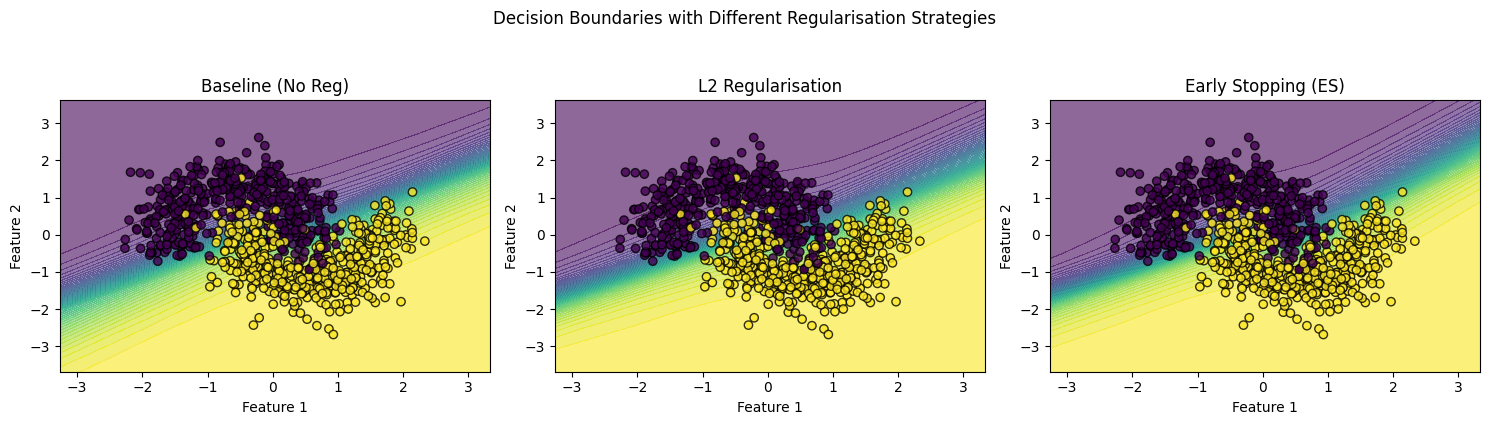


=== Compact Table for Report ===
               name  weight_decay  use_early_stopping  effective_epochs  train_acc  val_acc  test_acc  generalisation_gap
  Baseline (No Reg)         0.000               False               200   0.896667 0.893333  0.883333            0.013333
  L2 Regularisation         0.001               False               200   0.896667 0.896667  0.896667            0.000000
Early Stopping (ES)         0.000                True               200   0.905556 0.900000  0.903333            0.002222


In [1]:
# Explicit vs Implicit Regularisation:
# L2 Weight Decay vs Early Stopping on a Neural Network

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# ----------------------------------------------------------------------
# 1. Data Generation and Preprocessing
# ----------------------------------------------------------------------
RANDOM_STATE = 42

X, y = make_moons(n_samples=1500, noise=0.25, random_state=RANDOM_STATE)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=RANDOM_STATE
)  # 60% train, 20% val, 20% test

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# ----------------------------------------------------------------------
# 2. Model Builder
# ----------------------------------------------------------------------
def build_mlp(input_dim, weight_decay=0.0):
    """
    Build a simple MLP with optional L2 weight decay.
    This stays fixed across experiments so only regularisation/optimisation changes.
    """
    if weight_decay > 0.0:
        reg = regularizers.l2(weight_decay)
    else:
        reg = None

    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu", kernel_regularizer=reg),
        layers.Dense(64, activation="relu", kernel_regularizer=reg),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# ----------------------------------------------------------------------
# 3. Custom Callback to Track Weight Norms
# ----------------------------------------------------------------------
class WeightNormTracker(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.weight_norms = []

    def on_epoch_end(self, epoch, logs=None):
        total_norm = 0.0
        total_params = 0
        for w in self.model.trainable_weights:
            arr = w.numpy()
            total_norm += np.sum(arr**2)
            total_params += arr.size
        total_norm = np.sqrt(total_norm)
        self.weight_norms.append(total_norm)

# ----------------------------------------------------------------------
# 4. Training Helper
# ----------------------------------------------------------------------
def run_experiment(
    name,
    weight_decay=0.0,
    use_early_stopping=False,
    max_epochs=200,
    batch_size=64,
    learning_rate=1e-2
):
    """
    Train a model under a specific regularisation regime and collect metrics.
    """
    model = build_mlp(X_train.shape[1], weight_decay=weight_decay)
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = []
    weight_tracker = WeightNormTracker()
    callbacks.append(weight_tracker)

    if use_early_stopping:
        early_cb = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=15,
            restore_best_weights=True
        )
        callbacks.append(early_cb)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks
    )

    # Evaluate on train/val/test
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss,   val_acc   = model.evaluate(X_val, y_val,   verbose=0)
    test_loss,  test_acc  = model.evaluate(X_test, y_test, verbose=0)

    # For early stopping, effective epochs = len(history.history["loss"])
    effective_epochs = len(history.history["loss"])

    results = {
        "name": name,
        "weight_decay": weight_decay,
        "use_early_stopping": use_early_stopping,
        "max_epochs": max_epochs,
        "effective_epochs": effective_epochs,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "test_loss": test_loss,
        "generalisation_gap": train_acc - test_acc,
    }

    return model, history, weight_tracker.weight_norms, results

# ----------------------------------------------------------------------
# 5. Run Experiments
#    - Baseline: no regularisation, long training
#    - L2: explicit weight decay
#    - Early Stopping: implicit regularisation via training dynamics
# ----------------------------------------------------------------------
experiments = []

configurations = [
    {"name": "Baseline (No Reg)",      "weight_decay": 0.0,   "use_es": False},
    {"name": "L2 Regularisation",      "weight_decay": 1e-3,  "use_es": False},
    {"name": "Early Stopping (ES)",    "weight_decay": 0.0,   "use_es": True},
]

histories = {}
weight_norms = {}
models = {}
results_list = []

for cfg in configurations:
    print(f"Running: {cfg['name']}")
    model, history, norms, res = run_experiment(
        name=cfg["name"],
        weight_decay=cfg["weight_decay"],
        use_early_stopping=cfg["use_es"],
        max_epochs=200,
        batch_size=64,
        learning_rate=0.01
    )
    models[cfg["name"]] = model
    histories[cfg["name"]] = history
    weight_norms[cfg["name"]] = norms
    results_list.append(res)

# Summary table
results_df = pd.DataFrame(results_list)
print("\n=== Summary of Regularisation Experiments ===")
print(results_df[[
    "name", "weight_decay", "use_early_stopping",
    "effective_epochs", "train_acc", "val_acc", "test_acc", "generalisation_gap"
]])

# ----------------------------------------------------------------------
# 6. Plot Training Curves: Loss and Accuracy
# ----------------------------------------------------------------------
def plot_metric(histories, metric, title, ylabel):
    plt.figure(figsize=(8, 5))
    for name, hist in histories.items():
        values = hist.history[metric]
        plt.plot(values, label=f"{name}")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_metric_train_val(histories, metric, title, ylabel):
    plt.figure(figsize=(10, 5))
    for name, hist in histories.items():
        train_vals = hist.history[metric]
        val_vals = hist.history["val_" + metric]
        epochs = range(1, len(train_vals) + 1)
        plt.plot(epochs, train_vals, linestyle="-",  label=f"{name} – train")
        plt.plot(epochs, val_vals, linestyle="--", label=f"{name} – val")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Loss curves
plot_metric_train_val(histories, "loss",
                      title="Training vs Validation Loss under Different Regularisation Regimes",
                      ylabel="Binary Cross-Entropy Loss")

# Accuracy curves
plot_metric_train_val(histories, "accuracy",
                      title="Training vs Validation Accuracy under Different Regularisation Regimes",
                      ylabel="Accuracy")

# ----------------------------------------------------------------------
# 7. Plot Weight Norms over Time
# ----------------------------------------------------------------------
plt.figure(figsize=(8, 5))
for name, norms in weight_norms.items():
    epochs = range(1, len(norms) + 1)
    plt.plot(epochs, norms, label=name)
plt.xlabel("Epoch")
plt.ylabel("L2 Norm of Weights")
plt.title("Evolution of Weight Norms under Explicit and Implicit Regularisation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 8. Decision Boundary Visualisation
# ----------------------------------------------------------------------
def plot_decision_boundary(model, X, y, title):
    # Create grid
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid, verbose=0)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=50, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", alpha=0.8)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()

plt.figure(figsize=(15, 4))
for i, cfg in enumerate(configurations, 1):
    name = cfg["name"]
    plt.subplot(1, 3, i)
    plot_decision_boundary(models[name], X_train, y_train,
                           title=name)
plt.suptitle("Decision Boundaries with Different Regularisation Strategies", y=1.05)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 9. Compact Table for Report (CSV-like print)
# ----------------------------------------------------------------------
print("\n=== Compact Table for Report ===")
report_table = results_df[[
    "name", "weight_decay", "use_early_stopping",
    "effective_epochs", "train_acc", "val_acc", "test_acc", "generalisation_gap"
]]
print(report_table.to_string(index=False))
